In [1]:
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm

In [2]:
class World:
    def __init__(self,time_span,time_interval,debug = False):
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval
        
    def append(self,obj):
        self.objects.append(obj)# world座標系にobjを入れる
        
    def draw(self):
        # グラフの用意
        fig = plt.figure(figsize = (4,4))# 8*8インチの図を用意 図を描くのに必要
        ax = fig.add_subplot(111) # サブプロット １行１列の１番目を作るという宣言
        ax.set_aspect('equal') # 縦横比を座標の値と揃える
        ax.set_xlim(-5,5) # x軸 -5m~5m
        ax.set_ylim(-5,5) # y軸 -5m~5m
        ax.set_xlabel("X",fontsize = 10) #ラベル
        ax.set_ylabel("Y",fontsize = 10)
        
        elems = []
        
        if self.debug:
            for i in range(1000):self.one_step(i,elems,ax) # デバッグ時にアニメーションをさせない
        else:
            # FuncAnimation内をupdate
            self.ani = anm.FuncAnimation(fig,self.one_step,fargs = (elems,ax),
                                         frames = int(self.time_span / self.time_interval)+1,
                                         interval = int(self.time_interval * 1000),repeat = False)
            plt.show()
        
    def one_step(self,i,elems,ax):
        while elems: elems.pop().remove() # 二重で描かれないように
        time_str = "t= %.2f[s]" % (self.time_interval * i)
        elems.append(ax.text(-4.4,4.5,time_str,fontsize = 10))
        for obj in self.objects:
            obj.draw(ax,elems)
            if hasattr(obj,"one_step"): obj.one_step(self.time_interval)

In [3]:
# 速度と角速度が格納されているクラスAgentからrobotの軌跡を決める
class IdealRobot:
    # None -> 無ければ無いでオブジェクトを作成
    # 最初にinitが行われる（１）
    def __init__(self,pose,agent = None,sensor = None,color = "black"):
        self.pose = pose
        self.r = 0.2 # r:ロボットの半径
        self.color = color
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor
        
   
    def draw(self,ax,elems):
        x,y,theta = self.pose # 位置と姿勢
        xn = x + self.r * math.cos(theta) # robotの先端座標 今は特に使ってない
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x,xn],[y,yn],color = self.color)
        
        # patches.Circle(xy = 原点,radius = 半径,fill = False,color = 色)
        c = patches.Circle(xy = (x,y),radius = self.r,fill = False,color = self.color) # 円を描く下準備
        elems.append(ax.add_patch(c)) # 円完成　あとは出力
        
        # ロボットの軌跡を描く処理
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses],[e[1] for e in self.poses],linewidth = 0.5,color = "black")
        
        if self.sensor:
            self.sensor.draw(ax,elems,self.poses[-2])
        
        if self.agent and hasattr(self.agent,"draw"):
            self.agent.draw(ax,elems)
    
    # 移動後の状態を返す
    # ２番目の処理 poseの更新
    @classmethod # __init__以外にも定義する
    def state_transition(cls,nu,omega,time,pose):
        t0 = pose[2] # t0 -> θ_t-1
        if math.fabs(omega) < 1e-10: # (w_t = 0)
            return pose + np.array([nu * math.cos(t0),nu * math.sin(t0),omega]) * time
        # 状態遷移関数処理
        else:
            return pose + np.array([nu / omega * (math.sin(t0 + omega * time) - math.sin(t0)),
                                    nu / omega * (-math.cos(t0 + omega * time) + math.cos(t0)),omega * time])
    
    # 姿勢の更新
    def one_step(self,time_interval):
        if not self.agent: return #self.agentが空
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu,omega = self.agent.decision(obs)
        # time_interval:１ステップが何秒か指定
        self.pose = self.state_transition(nu,omega,time_interval,self.pose)
        
# one_stepで時間周期を入力、νとωを取り出す　これらをstate_transitionへ
# self_transitionは、状態遷移関数
# 以上の処理をして、新たなposeを使い、drawで描く　という順番

In [4]:
class Agent: # 引数(速度,角速度)
    def __init__(self,nu,omega):
        self.nu = nu;
        self.omega = omega
    
    # selfに格納されているパラメータをバラす
    def decision(self,observation = None):
        return self.nu,self.omega
    

In [5]:
class Landmark:
    def __init__(self,x,y):
        self.pos = np.array([x,y]).T
        self.id = None
        
    def draw(self,ax,elems):
        # s:点のサイズ
        c = ax.scatter(self.pos[0],self.pos[1],s = 100,marker = "*",label = "landmarks",color = "orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0],self.pos[1],"id" + str(self.id),fontsize = 10))

In [6]:
class Map:
    def __init__(self):
        self.landmarks = [] # 空のランドマークのリスト
    
    def append_landmark(self,landmark): # ランドマーク追加関数
        landmark.id = len(self.landmarks)    # 追加するランドマークのIDを与える
        self.landmarks.append(landmark)
        
    def draw(self,ax,elems):            # ランドマークの作図(map内に描画) 
        for lm in self.landmarks: lm.draw(ax,elems)        

In [7]:
class IdealCamera:
    def __init__(self,env_map,\
                distance_range = (0.5,6.0),
                direction_range = (-math.pi/3,math.pi/3)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self,polarpos):
        if polarpos is None:
            return False
        
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1]\
                and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
    
        
    def data(self,cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose,lm.pos) # 関数h
            if self.visible(z):
                observed.append((z,lm.id))
        
        self.lastdata = observed
        return observed
    
    # 出力方程式 landmarkとrobotとの距離と相対角度を出力
    # カメラとlandmarkの位置が引数 *cameraとロボットは同じ方向を向いているものとする
    @classmethod
    def observation_function(cls,cam_pose,obj_pos):        
        diff = obj_pos - cam_pose[0:2]
        # (x,y) = (diff[0],diff[1]) cam_pose[2] -> θ
        phi = math.atan2(diff[1],diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2 * np.pi # -π~πに収まるように正規化
        while phi < -np.pi: phi += 2 * np.pi
        
        return np.array([np.hypot(*diff),phi]).T
    
    def draw(self,ax,elems,cam_pose):
        for lm in self.lastdata:
            x,y,theta = cam_pose
            distance  = lm[0][0]
            direction = lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx],[y,ly],color = "pink")

<IPython.core.display.Javascript object>


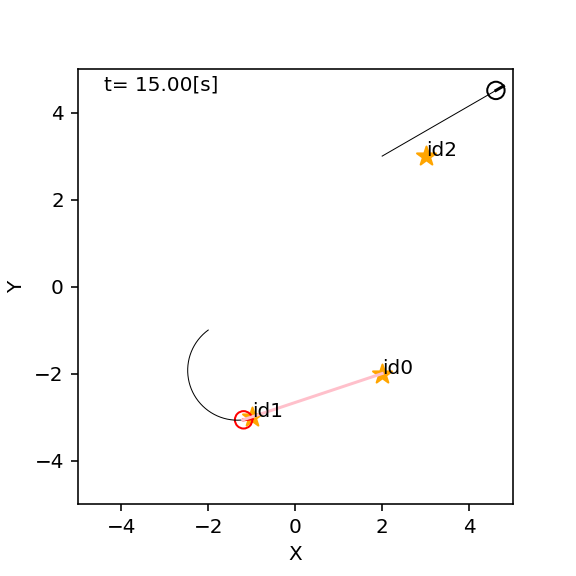

In [10]:
if __name__ == '__main__':
    world = World(15.0,0.1) # elemsはclass Worldで用意される

    m = Map()
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(-1,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m) # マップ座標をworld座標に合わせる

    straight = Agent(0.2,0.0)
    circling = Agent(0.2,10.0 / 180 * math.pi)
    robot1 = IdealRobot(np.array([2,3,math.pi/6]).T, sensor = IdealCamera(m),agent = straight) #(x,y,θ) = (2,3,π/6) .T -> 転置
    robot2 = IdealRobot(np.array([-2,-1,math.pi/5*6]).T, sensor = IdealCamera(m),agent = circling,color = "red")
    #robot3 = IdealRobot(np.array([0,0,0]).T,color = "blue")

    world.append(robot1)
    world.append(robot2)
    #world.append(robot3)

    world.draw()

In [9]:
cam = IdealCamera(m)
p = cam.data(robot2.pose)
p # 各landmarkとrobot2との距離
#print(p)

[]